In [2]:
import calculate_return as cr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from math import sqrt
import sharpe
from scipy.stats import jarque_bera 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 1000)
plt.style.use('seaborn')
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('figure', titlesize=13)  # fontsize of the figure title
w = 

In [3]:
# Fetching baseline data
ports = cr.fetch_returns('garch', range(10000))

In [2]:
ports_1000 = cr.fetch_returns('garch', range(1000))

In [6]:
sharpe.CE_ports(ports, risk_premium = True)

,dual_phase,single_phase,100,9050
Certainty Equivalent,102.258,87.756,132.681,50.127


In [27]:
CE_data = ports[["dual_phase","single_phase","100","9050"]]
max_date = max(ports.index.levels[1])
CE_data = CE_data.loc[(slice(None), max_date),:].reset_index()
CE_data = CE_data.drop(["period"], axis=1).set_index("random_state")

In [28]:
CE_list = []
for strategy in ['dual_phase', 'single_phase', '100', '9050']:
    input_list=CE_data[strategy][abs(CE_data[strategy]) > 10000].to_list()
    len_list = len(input_list)
    CE_val = (1/len_list)**(1/(1-2))*sum([(x)**(1-2) for x in input_list])**(1/(1-2))
    CE_list.append(pd.DataFrame([CE_val], columns=[strategy]))

CE_list = pd.concat(CE_list, axis=1)
CE_list.index = pd.Index(['Certainty Equivalent'])

In [31]:
(CE_data.mean()/CE_list-1)*100

,dual_phase,single_phase,100,9050
Certainty Equivalent,102.258,87.756,132.681,50.127


In [38]:
CE_list

,dual_phase,single_phase,100,9050
Certainty Equivalent,1828156.107,1896823.990,1351046.578,1593942.760


In [52]:
import datetime as dt

(18262.0, 25567.0)

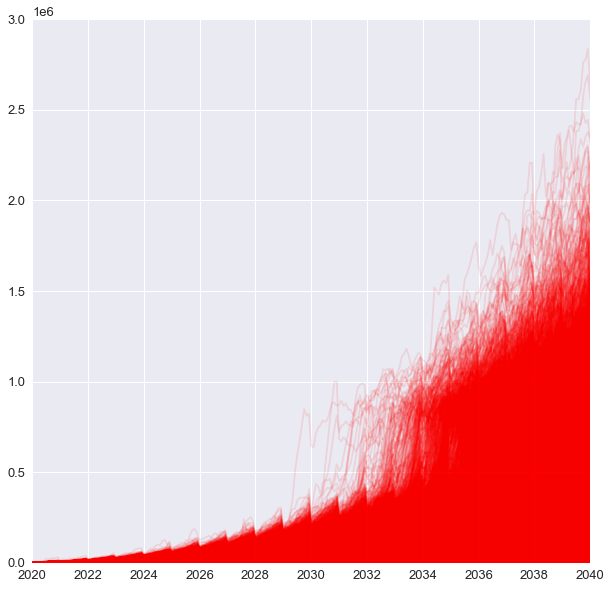

In [55]:
f, ax = plt.subplots(figsize=(10,10))
ax.plot(ports.reset_index(level=0).pivot(columns = 'random_state', values='dual_phase'), color='red', alpha=0.1)
ax.set_ylim(0, 0.1e7)
ax.set_xlim(dt.date(2020, 1, 1), dt.date(2040, 1, 1))

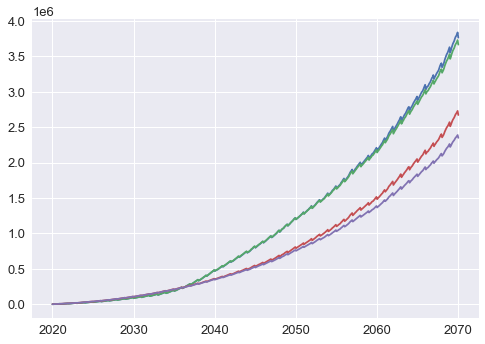

In [3]:
plt.plot(ports.groupby(level=1).mean().loc[:, ['dual_phase', 'single_phase', '100', '9050']])

In [4]:
sharpe_ratio = sharpe.calculate_sharpe(ports)

In [9]:
sharpe_ratio.describe()

,Dual phase,Single phase,100% stocks,Life cycle
count,9939.000,9939.000,9939.000,9939.000
mean,0.161,0.159,0.152,0.124
std,0.090,0.090,0.088,0.092
min,-0.331,-0.331,-0.201,-0.152
25%,0.115,0.113,0.093,0.061
50%,0.174,0.171,0.146,0.119
75%,0.222,0.218,0.208,0.182
max,0.478,0.467,0.516,0.766


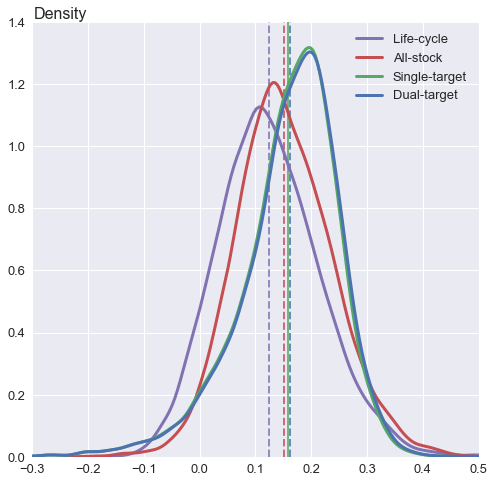

In [29]:
f, ax = plt.subplots(figsize=(8, 8))
ax = sns.kdeplot(data = sharpe_ratio, linewidth = 3)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.set_ylabel("Density", loc='top', rotation=0, labelpad=-80)
ax.set_xlabel("")
ax.set_ylim(0, 1.4)
ax.set_xlim(-0.3, 0.5)
labs = ['Dual-target', 'Single-target', 'All-stock', 'Life-cycle']
labs.reverse()
ax.legend(labs)
for i, strategy in enumerate(['Dual phase', 'Single phase', '100% stocks', 'Life cycle']):
    if strategy == "Single phase":
        ax.vlines(sharpe_ratio[strategy].mean(), ymin= 0, ymax=1.4, color = cycle[i], linestyle="solid", alpha = 0.8, linewidth = 2)
    else:
        ax.vlines(sharpe_ratio[strategy].mean(), ymin= 0, ymax=1.4, color = cycle[i], linestyle="--", alpha = 0.8, linewidth = 2)

f.savefig("Empirical/sharpe_distribution.png", bbox_inches = 'tight', pad_inches = 0.1, dpi=192)

### Removing defaulted investors

In [12]:
zz = ports.loc[(slice(None), '2070-01-01'),:]
zzz = zz[zz['tv_u'] > 0].reset_index()
non_defaulted=zzz['random_state'].tolist()
non_defaulted_df=ports.loc[non_defaulted,:]


In [16]:
sharpe_ratio_no_def = sharpe.calculate_sharpe(non_defaulted_df)

<AxesSubplot:ylabel='Density'>

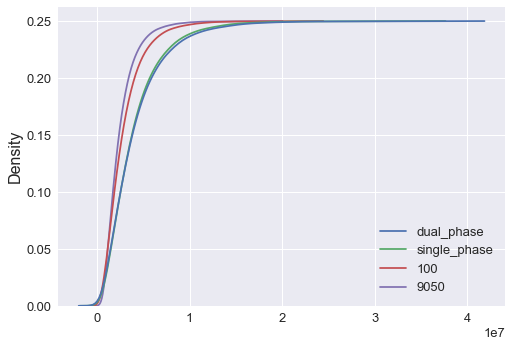

In [33]:
sns.kdeplot(data = ports.loc[(slice(None), '2070-01-01'), ['dual_phase', 'single_phase', '100', '9050']], clip=(-1e7, 5e7), cumulative=True)

In [33]:
ports.loc[(slice(None), '2070-01-01'), ['dual_phase', 'single_phase', '100', '9050']].describe()

NameError: name 'sharpe_ratios' is not defined

In [54]:
df = ports
df['total_return_dual_phase'] = df.groupby(level=0, as_index=False).apply(lambda x: x.dual_phase/x.savings.cumsum()).reset_index(level=0, drop=True)

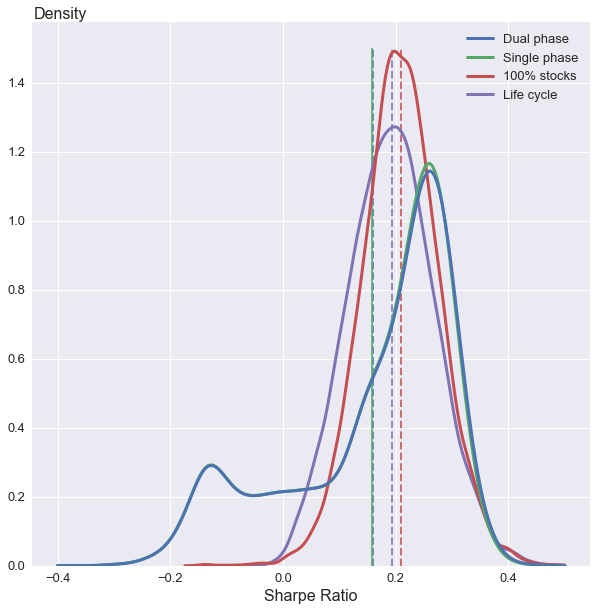

In [17]:
f, ax = plt.subplots(figsize=(10,10))
ax = sns.kdeplot(data = sharpe_ratio_no_def, linewidth = 3, clip= (-0.4, 0.5))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.set_ylabel("Density", loc='top', rotation=0, labelpad=-80)
ax.set_xlabel("Sharpe Ratio")
for i, strategy in enumerate(['Dual phase', 'Single phase', '100% stocks', 'Life cycle']):
    if strategy == "Single phase":
        ax.vlines(sharpe_ratio_no_def[strategy].mean(), ymin= 0, ymax=1.5, color = cycle[i], linestyle="solid", alpha = 0.8, linewidth = 2)
    else:
        ax.vlines(sharpe_ratio_no_def[strategy].mean(), ymin= 0, ymax=1.5, color = cycle[i], linestyle="--", alpha = 0.8, linewidth = 2)
#f.savefig("Empirical/sharpe_distribution.png", bbox_inches = 'tight', pad_inches = 0.1)

In [9]:
ports.loc[(slice(None), '2070-01-01'), ['dual_phase', 'single_phase']].describe()

,dual_phase,single_phase
count,10000.000,10000.000
mean,3838926.962,3733564.218
std,3351444.133,3102507.092
min,-374386.645,-374386.645
25%,1578737.465,1619016.953
50%,3005684.776,2996312.394
75%,5058007.315,4923403.961
max,40273208.896,36180303.103


In [7]:
sharpe_ratio.describe()

,Dual phase,Single phase,100% stocks,Life cycle
count,9939.000,9939.000,9939.000,9939.000
mean,0.161,0.159,0.152,0.124
std,0.090,0.090,0.088,0.092
min,-0.331,-0.331,-0.201,-0.152
25%,0.115,0.113,0.093,0.061
50%,0.174,0.171,0.146,0.119
75%,0.222,0.218,0.208,0.182
max,0.478,0.467,0.516,0.766


In [91]:
ports.loc[(1, slice(None)), :].savings.cumsum().max()

832764

In [212]:
cum_savings = ports.loc[(1, slice(None)), :].savings.cumsum().max()

In [139]:
ports['100']/ports.loc[(slice(None), '2070-01-01'), '100'].groupby(level=0).mean()

random_state  period    
0             2020-01-01   0.001
              2020-02-01   0.001
              2020-03-01   0.002
              2020-04-01   0.003
              2020-05-01   0.004
                            ... 
399           2069-09-01   1.012
              2069-10-01   0.885
              2069-11-01   0.975
              2069-12-01   0.986
              2070-01-01   1.000
Name: 100, Length: 240400, dtype: float64

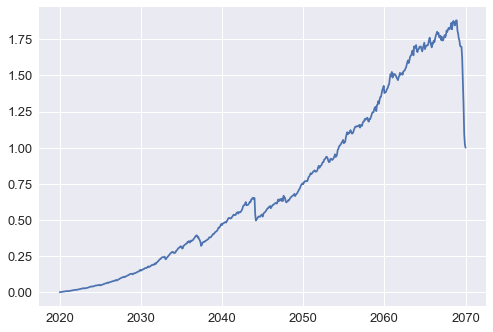

In [213]:
plt.plot((ports['100']/ports.loc[(slice(None), '2070-01-01'), '100'].groupby(level=0).mean()).groupby(level=1).mean())

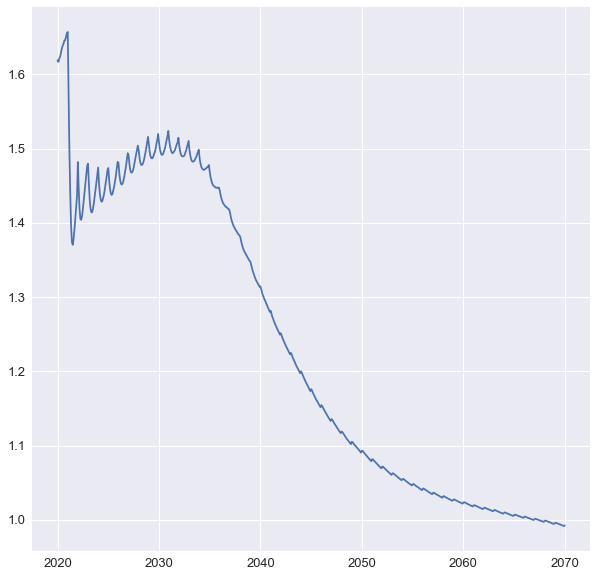

In [306]:
f, ax = plt.subplots(figsize=(10,10))
ax.plot((ports.pv_u/ports.pv_u.groupby(level=0).max()).groupby(level=1).mean()/(ports['100']/ports['100'].groupby(level=0).max()).groupby(level=1).mean())
#ax.plot((ports.pv_u/ports.pv_u.groupby(level=0).max()).groupby(level=1).mean())
#ax.plot((ports['100']/ports['100'].groupby(level=0).max()).groupby(level=1).mean())

In [32]:
limit = 250000

In [33]:
ports['end_pv_u'] = ports.groupby(level=0).take([-1])[['dual_phase']].reset_index(level=0, drop=True)

In [34]:
ports.end_pv_u = ports.end_pv_u.bfill()

In [35]:
ports['end_100'] = ports.groupby(level=0).take([-1])[['100']].reset_index(level=0, drop=True)

In [36]:
ports.end_100 = ports.end_100.bfill()

In [37]:
ports = ports[ports['end_pv_u'].abs() > limit]
ports = ports[ports['end_100'].abs() > limit]

In [44]:
ports.head()

savings  cash  new_equity  new_debt  total_debt  \
random_state period                                                        
1            2020-01-01      450     0         450       450         450   
             2020-02-01      457     0         457       457         907   
             2020-03-01      465     0         465       412        1320   
             2020-04-01      473     0         473       412        1733   
             2020-05-01      481     0         481       737        2471   

                             nip  pv_p  interest  market_returns     pv_u  \
random_state period                                                         
1            2020-01-01  900.000   900         1           0.000  900.000   
             2020-02-01  915.613  1815         3          -0.027 1762.641   
             2020-03-01  878.186  2640         4          -0.021 2580.389   
             2020-04-01  886.200  3466         5           0.076 3723.494   
             2020-05-01 1218.954  4942         8           0.010 4983.303   

                         tv_u   equity     dst  phase  pi_hat  g_hat  SU_debt  \
random_state period                                                             
1            2020-01-01   900  450.000  748773      1   0.001  1.000  450.000   
             2020-02-01  1762  854.834  748773      1   0.002  1.062  907.806   
             2020-03-01  2580 1259.976  748773      1   0.003  1.048 1320.414   
             2020-04-01  3723 1990.200  748773      1   0.004  0.871 1733.295   
             2020-05-01  4983 2512.079  748773      1   0.006  0.984 2471.224   

                         Nordnet_debt    rf    rm  pi_rf  pi_rm  dual_phase  \
random_state period                                                           
1            2020-01-01         0.000 0.002 0.002  0.952  0.899     450.000   
             2020-02-01         0.000 0.002 0.002  0.952  0.899     854.834   
             2020-03-01         0.000 0.002 0.002  0.952  0.899    1259.976   
             2020-04-01         0.000 0.002 0.002  0.952  0.899    1990.200   
             2020-05-01         0.000 0.002 0.002  0.952  0.899    2512.079   

                         single_phase   100  9050  total_return_dual_phase  \
random_state period                                                          
1            2020-01-01       450.000   450   450                   -3.248   
             2020-02-01       854.834   882   885                   -0.058   
             2020-03-01      1259.976  1319  1325                   -0.026   
             2020-04-01      1990.200  1929  1920                    0.175   
             2020-05-01      2512.079  2434  2423                    0.001   

                         total_return_single_phase  total_return_100  \
random_state period                                                    
1            2020-01-01                     -3.248            -0.261   
             2020-02-01                     -0.058            -0.028   
             2020-03-01                     -0.026            -0.011   
             2020-04-01                      0.175             0.088   
             2020-05-01                      0.001             0.001   

                         total_return_9050   end_pv_u    end_100  
random_state period                                               
1            2020-01-01             -0.434 869031.297 774048.000  
             2020-02-01             -0.024 869031.297 774048.000  
             2020-03-01             -0.010 869031.297 774048.000  
             2020-04-01              0.078 869031.297 774048.000  
             2020-05-01              0.001 869031.297 774048.000

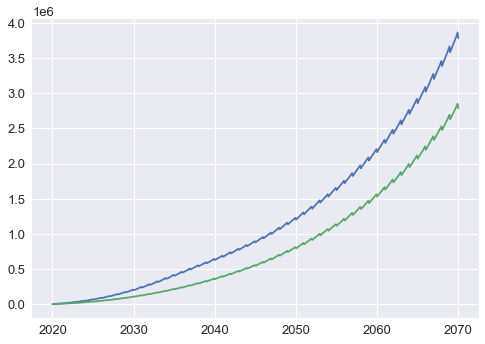

In [56]:
plt.plot((ports['pv_u']).groupby(level=1).mean())
plt.plot((ports['100']).groupby(level=1).mean())

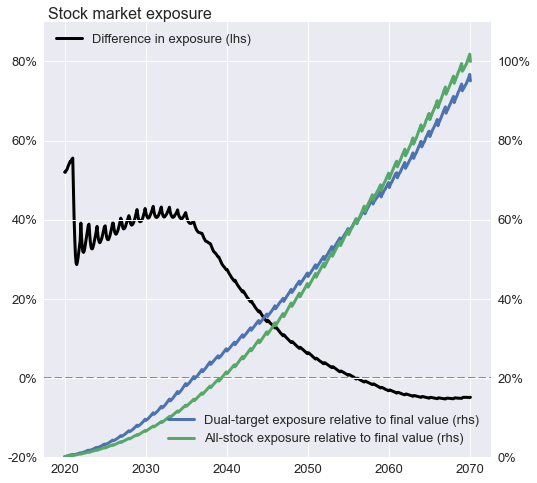

In [43]:
f, ax = plt.subplots(figsize=(8,8))
ax.plot((ports['pv_u']*100/ports['end_pv_u']).groupby(level=1).mean()/(ports['100']/ports['end_100']).groupby(level=1).mean()-100, color='black', linewidth = 3)
ax2 = ax.twinx()
ax2.plot((ports['pv_u']*100/ports['end_pv_u']).groupby(level=1).mean(), linewidth = 3)
ax2.plot((ports['100']*100/ports['end_100']).groupby(level=1).mean(), linewidth = 3)
ax.set_ylim(-20, 90)
ax2.set_ylim(0, 110)
ax.axhline(0, color = 'red', linestyle='dashed', linewidth=2, alpha = .6)
ax.set_ylabel("Stock market exposure", rotation=0, loc='top', labelpad=-205) 
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f'{x:.0f}%'))
ax2.legend(['Dual-target exposure relative to final value (rhs)', 'All-stock exposure relative to final value (rhs)'], loc='lower right')
ax.legend(['Difference in exposure (lhs)'], loc='upper left')
f.savefig('Empirical/stock_market_exposure.png', bbox_inches = 'tight', pad_inches = 0.1, dpi=192)

### Testing for normality

#### Sharpe ratio

In [4]:
sharpe_ratio = sharpe.calculate_sharpe(ports)

In [8]:
ports['total_return_dual_phase'] = ports.groupby(level=0, as_index=False).apply(lambda x: x.dual_phase/x.savings.cumsum()).reset_index(level=0, drop=True).pct_change().fillna(0)

In [10]:
no_ex = ports[ports.total_return_dual_phase.abs() < 1] 

In [11]:
jarque_bera(no_ex.total_return_dual_phase.values)

Jarque_beraResult(statistic=64257167.453091465, pvalue=0.0)

<AxesSubplot:xlabel='total_return_dual_phase', ylabel='Density'>

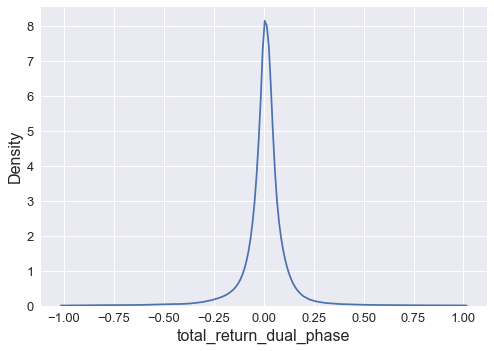

In [13]:
sns.kdeplot(data = no_ex.total_return_dual_phase)

In [5]:
jarque_bera(sharpe_ratio.iloc[:, 0].values)

Jarque_beraResult(statistic=2710.588149742223, pvalue=0.0)

#### Terminal wealth

In [6]:
jarque_bera(ports.loc[(slice(None), '2070-01-01'), ['dual_phase']].values)

Jarque_beraResult(statistic=60945.508411693336, pvalue=0.0)

In [ ]:
jarque_bera